# Computer vision : pneumonia XRay

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.


https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

#### Enabling GPU

In [15]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

#### Loading libraries 

In [16]:
import cv2
import numpy as np
import pandas as pd
from glob import glob
from matplotlib import pyplot as plt
import itertools
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,Activation,GlobalMaxPool2D,GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.utils import to_categorical  
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score 
from sklearn.datasets import load_files


#### Loading data set

Train set

In [17]:
path = "../../Asset/chest_xray/train/*/*.jpeg"  # The path to all images in training set. (* means include all folders and files.)
files = glob(path)
# print(files)
trainImg = [] # Initialize empty list to store the image data as numbers.
trainLabel = [] # Initialize empty list to store the labels of images
j = 1
num = len(files)

# Obtain images and resizing, obtain labels
for img in files:
    '''
    Append the image data to trainImg list.
    Append the labels to trainLabel list.
    '''
    print(str(j) + "/" + str(num), end="\r")
    image = cv2.imread(img)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    trainImg.append(cv2.resize(gray, (128, 128)))  # Get image (with resizing to 128 x 128)
    trainLabel.append(img.split('/')[4].split('\\')[-2])  # Get image label (folder name contains the class to which the image belong)
    j += 1

trainImg = np.asarray(trainImg)  # Train images set
trainLabel = pd.DataFrame(trainLabel)  # Train labels set

In [18]:
print(trainImg.shape)
print(trainLabel.shape)
trainLabel[0].value_counts()

(5216, 128, 128)
(5216, 1)


PNEUMONIA    3875
NORMAL       1341
Name: 0, dtype: int64

In [19]:
# Categorizing y_train label variable
labels = preprocessing.LabelEncoder()
labels.fit(trainLabel[0])
print('Classes'+str(labels.classes_))
encodedlabel = labels.transform(trainLabel[0])
y_train = tf.keras.utils.to_categorical(encodedlabel)
classes = y_train.shape[1]
print(str(classes))
# normalization of x_train images
X_train = trainImg.astype('float32') / 255.0
X_train = X_train.reshape(X_train.shape[0],128,128,1)


Classes['NORMAL' 'PNEUMONIA']
2


Preparing Test sets

In [20]:
path = "../../Asset/chest_xray/test/*/*.jpeg"  # The path to all images in testing set. (* means include all folders and files.)
files = glob(path)

testImg = [] # Initialize empty list to store the image data as numbers.
testLabel = [] # Initialize empty list to store the labels of images
j = 1
num = len(files)

# Obtain images and resizing, obtain labels
for img in files:
    '''
    Append the image data to trainImg list.
    Append the labels to trainLabel list.
    '''
    print(str(j) + "/" + str(num), end="\r")
    image = cv2.imread(img)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    testImg.append(cv2.resize(gray, (128, 128)))  # Get image (with resizing to 128 x 128)
    testLabel.append(img.split('/')[4].split('\\')[-2])  # Get image label (folder name contains the class to which the image belong)
    j += 1

testImg = np.asarray(testImg)  # test images set
testLabel = pd.DataFrame(testLabel)  # testlabels set

In [21]:
print(testImg.shape)
print(testLabel.shape)

(624, 128, 128)
(624, 1)


In [22]:
# Categorizing y_train label variable
labels = preprocessing.LabelEncoder()
labels.fit(testLabel[0])
print('Classes'+str(labels.classes_))
encodedlabel = labels.transform(testLabel[0])
y_test = tf.keras.utils.to_categorical(encodedlabel)
classes = y_test.shape[1]
print(str(classes))
# normalization of x_train images
X_test = testImg.astype('float32') / 255.0
X_test = X_test.reshape(X_test.shape[0],128,128,1)

Classes['NORMAL' 'PNEUMONIA']
2


Validation set

In [23]:
path = "../../Asset/chest_xray/val/*/*.jpeg"  # The path to all images in testing set. (* means include all folders and files.)
files = glob(path)

valImg = [] # Initialize empty list to store the image data as numbers.
valLabel = [] # Initialize empty list to store the labels of images
j = 1
num = len(files)

# Obtain images and resizing, obtain labels
for img in files:
    '''
    Append the image data to trainImg list.
    Append the labels to trainLabel list.
    '''
    print(str(j) + "/" + str(num), end="\r")
    image = cv2.imread(img)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    valImg.append(cv2.resize(gray, (128, 128)))  # Get image (with resizing to 128 x 128)
    valLabel.append(img.split('/')[4].split('\\')[-2])  # Get image label (folder name contains the class to which the image belong)
    j += 1

valImg = np.asarray(valImg)  # test images set
valLabel = pd.DataFrame(valLabel)  # testlabels set

In [24]:
print(valImg.shape)
print(valLabel.shape)
valLabel[0].value_counts()

(16, 128, 128)
(16, 1)


NORMAL       8
PNEUMONIA    8
Name: 0, dtype: int64

In [25]:
# Categorizing y_train label variable
labels = preprocessing.LabelEncoder()
labels.fit(valLabel[0])
print('Classes'+str(labels.classes_))
encodedlabel = labels.transform(valLabel[0])
y_val = tf.keras.utils.to_categorical(encodedlabel)
classes = y_val.shape[1]
print(str(classes))
# normalization of x_train images
X_val = valImg.astype('float32') / 255.0
X_val = X_val.reshape(X_val.shape[0],128,128,1)

Classes['NORMAL' 'PNEUMONIA']
2


#### Preview some samples

Text(0.5, 1.0, 'NORMAL')

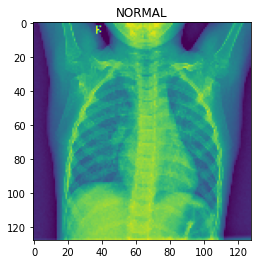

In [16]:
plt.imshow(trainImg[0])
plt.title(trainLabel[0][0])

Text(0.5, 1.0, 'PNEUMONIA')

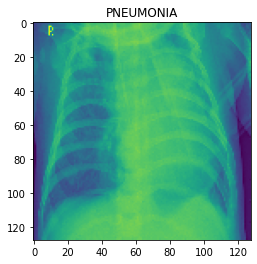

In [17]:
plt.imshow(trainImg[3000])
plt.title(trainLabel[0][3000])

#### Confusion matrix function

In [33]:
# confusion matrix function

def plot_confusion_matrix(cm, classes, normalize=False,title='Confusion matrix',cmap=plt.cm.Greens):
    
    fig = plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=50)

    plt.tight_layout()
    plt.ylabel('Actual label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

#### Data augmentation

In [106]:
# generator = ImageDataGenerator(rotation_range = 40,
#                                zoom_range = 0.2,
#                                shear_range=0.2,
#                                width_shift_range = 0.2,
#                                height_shift_range = 0.2,
#                                horizontal_flip = True,
#                                vertical_flip = True,
#                                fill_mode='nearest')
# generator.fit(X_train)

## CNN model 1

*   3 convolution layers ( filters=128/64/32, kernel_size=(3, 3) activation='relu')
*   MaxPool2D((2, 2)
*   Dropout(0.25)
*   Flatten
*   3 dense layers (256/128/64, activation='relu')
*   model.add(Dense(2, activation='sigmoid'))
*   Dropout(0.5)
*   loss='binary_crossentropy', optimizer='adam'
*   shuffle = True 
*   no data augmentation 
*   Batch size : 16
*   Epochs : 50

In [42]:
model = Sequential()

model.add(Conv2D(filters=128, kernel_size=(3, 3), input_shape=(128, 128, 1), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 126, 126, 128)     1280      
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 63, 63, 128)       0         
_________________________________________________________________
dropout_41 (Dropout)         (None, 63, 63, 128)       0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 61, 61, 64)        73792     
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_42 (Dropout)         (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 28, 28, 32)       

In [43]:
with tf.device('/GPU:0'):
    es = EarlyStopping(monitor='val_loss', mode='min',  verbose=1, patience=70, min_delta =0.01)
    mc = ModelCheckpoint('../models/best_model1.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

    history = model.fit(generator.flow(X_train,y_train,batch_size=16),epochs=50, verbose=1,shuffle=True,validation_data=(X_test,y_test), callbacks=[es, mc])

Epoch 1/50
326/326 [==============================] - 13s 35ms/step - loss: 0.5956 - accuracy: 0.7187 - val_loss: 0.7196 - val_accuracy: 0.6250

Epoch 00001: val_accuracy improved from -inf to 0.62500, saving model to best_model1.h5
Epoch 2/50
326/326 [==============================] - 11s 33ms/step - loss: 0.4775 - accuracy: 0.7457 - val_loss: 0.6067 - val_accuracy: 0.6298

Epoch 00002: val_accuracy improved from 0.62500 to 0.62981, saving model to best_model1.h5
Epoch 3/50
326/326 [==============================] - 11s 33ms/step - loss: 0.4447 - accuracy: 0.7764 - val_loss: 0.6813 - val_accuracy: 0.6731

Epoch 00003: val_accuracy improved from 0.62981 to 0.67308, saving model to best_model1.h5
Epoch 4/50
326/326 [==============================] - 11s 33ms/step - loss: 0.3893 - accuracy: 0.8174 - val_loss: 0.6513 - val_accuracy: 0.7212

Epoch 00004: val_accuracy improved from 0.67308 to 0.72115, saving model to best_model1.h5
Epoch 5/50
326/326 [==============================] - 11s 3

In [11]:
SAVED_MODEL_PATH = '../models/best_model1.h5'
saved_model = load_model(SAVED_MODEL_PATH)

In [45]:
#Final score and accuracy of the model
score, acc = saved_model.evaluate(X_train,y_train)
score1, acc1 = saved_model.evaluate(X_test,y_test)
score2, acc2 = saved_model.evaluate(X_val,y_val)
print('Train score:', score,'   Train accuracy:', acc)
print('Test score:', score1,'   Test accuracy:',acc1)
print('Val score:', score2,'   Val accuracy:',acc2)

1/1 [==============================] - 0s 22ms/step - loss: 0.5380 - accuracy: 0.6875
Train score: 0.1709810048341751    Train accuracy: 0.9353911280632019
Test score: 0.30140015482902527    Test accuracy: 0.9118589758872986
Val score: 0.5379834175109863    Val accuracy: 0.6875


## CNN model 2

*   6 convolution layers ( filters=32/32/64/64/128/128, kernel_size=(3, 3) activation='relu')
*   MaxPool2D((2, 2)
*   Dropout(0.25)
*   Flatten
*   1 dense layer (1024, activation='relu')
*   model.add(Dense(2, activation='sigmoid'))
*   Dropout(0.5)
*   loss='binary_crossentropy', optimizer='adam'
*   shuffle = True 
*   data augmentation : 
                        (rotation_range = 20, 
                        zoom_range = 0.2, 
                        width_shift_range = 0.2, 
                        height_shift_range = 0.2, 
                        horizontal_flip = True, 
                        vertical_flip = True)
*   Batch size : 16
*   Epochs : 50

In [46]:
generator = ImageDataGenerator(rotation_range = 20,
                               zoom_range = 0.2,
                               width_shift_range = 0.2,
                               height_shift_range = 0.2,
                               horizontal_flip = True,
                               vertical_flip = True)
generator.fit(X_train)

In [47]:
model = Sequential()

model.add(Conv2D(filters=32,padding='same', kernel_size=(3, 3), input_shape=(128, 128, 1), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=32,padding='same', kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64,padding='same', kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64,padding='same', kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128,padding='same', kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128,padding='same', kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(2, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_43 (Conv2D)           (None, 128, 128, 32)      320       
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_47 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_48 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 32, 32, 64)       

In [48]:
with tf.device('/GPU:0'):
    es = EarlyStopping(monitor='val_loss', mode='min',  verbose=1, patience=70, min_delta =0.01)
    mc = ModelCheckpoint('../models/best_model2.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

    history = model.fit(generator.flow(X_train,y_train,batch_size=16),epochs=100, verbose=1,shuffle=True,validation_data=(X_test,y_test), callbacks=[es, mc])
    pd.DataFrame(history.history)

Epoch 1/100
326/326 [==============================] - 7s 18ms/step - loss: 0.5814 - accuracy: 0.7383 - val_loss: 0.8079 - val_accuracy: 0.5817

Epoch 00001: val_accuracy improved from -inf to 0.58173, saving model to best_model2.h5
Epoch 2/100
326/326 [==============================] - 6s 18ms/step - loss: 0.4754 - accuracy: 0.7321 - val_loss: 0.6348 - val_accuracy: 0.6971

Epoch 00002: val_accuracy improved from 0.58173 to 0.69712, saving model to best_model2.h5
Epoch 3/100
326/326 [==============================] - 6s 18ms/step - loss: 0.4643 - accuracy: 0.7543 - val_loss: 0.6921 - val_accuracy: 0.6827

Epoch 00003: val_accuracy did not improve from 0.69712
Epoch 4/100
326/326 [==============================] - 6s 17ms/step - loss: 0.4502 - accuracy: 0.7733 - val_loss: 0.7281 - val_accuracy: 0.7115

Epoch 00004: val_accuracy improved from 0.69712 to 0.71154, saving model to best_model2.h5
Epoch 5/100
326/326 [==============================] - 6s 17ms/step - loss: 0.4594 - accuracy: 


Epoch 00079: val_accuracy did not improve from 0.79968
Epoch 80/100
326/326 [==============================] - 6s 18ms/step - loss: 0.1906 - accuracy: 0.9216 - val_loss: 0.6753 - val_accuracy: 0.7260

Epoch 00080: val_accuracy did not improve from 0.79968
Epoch 81/100
326/326 [==============================] - 6s 17ms/step - loss: 0.1901 - accuracy: 0.9253 - val_loss: 0.6188 - val_accuracy: 0.7692

Epoch 00081: val_accuracy did not improve from 0.79968
Epoch 82/100
326/326 [==============================] - 6s 17ms/step - loss: 0.2141 - accuracy: 0.9169 - val_loss: 0.5916 - val_accuracy: 0.7564

Epoch 00082: val_accuracy did not improve from 0.79968
Epoch 83/100
326/326 [==============================] - 6s 18ms/step - loss: 0.1982 - accuracy: 0.9234 - val_loss: 0.7982 - val_accuracy: 0.7051

Epoch 00083: val_accuracy did not improve from 0.79968
Epoch 84/100
326/326 [==============================] - 6s 18ms/step - loss: 0.1969 - accuracy: 0.9215 - val_loss: 0.6444 - val_accuracy: 0.

In [94]:
SAVED_MODEL_PATH = '../models/best_model2.h5'
saved_model = load_model(SAVED_MODEL_PATH)

In [97]:
#Final score and accuracy of the model
score, acc = saved_model.evaluate(X_train,y_train)
score1, acc1 = saved_model.evaluate(X_test,y_test)
score2, acc2 = saved_model.evaluate(X_val,y_val)
print('Train score:', score,'   Train accuracy:', acc)
print('Test score:', score1,'   Test accuracy:',acc1)
print('Val score:', score2,'   Val accuracy:',acc2)

1/1 [==============================] - 0s 30ms/step - loss: 0.1885 - accuracy: 0.8750
Train score: 0.16693894565105438    Train accuracy: 0.9267638325691223
Test score: 0.34023958444595337    Test accuracy: 0.9214743375778198
Val score: 0.18854914605617523    Val accuracy: 0.875


### CNN model 3

*   7 convolution layers ( filters=32/32/32/64/64/128/128, kernel_size=(3, 3) activation='relu')
*   MaxPool2D((2, 2)
*   Dropout(0.25)
*   Flatten
*   1 dense layer (1024, activation='relu')
*   model.add(Dense(2, activation='sigmoid'))
*   Dropout(0.5)
*   loss='binary_crossentropy', optimizer='adam'
*   shuffle = True 
*   data augmentation : 
                        (rotation_range = 20, 
                        zoom_range = 0.2, 
                        width_shift_range = 0.2, 
                        height_shift_range = 0.2, 
                        horizontal_flip = True, 
                        vertical_flip = True)
*   Batch size : 16
*   Epochs : 100

In [20]:
generator = ImageDataGenerator(rotation_range = 20,
                               zoom_range = 0.2,
                               width_shift_range = 0.2,
                               height_shift_range = 0.2)
generator.fit(X_train)

In [21]:
model = Sequential()

model.add(Conv2D(filters=32,padding='same', kernel_size=(3, 3), input_shape=(128, 128, 1), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=32,padding='same', kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=32,padding='same', kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64,padding='same', kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64,padding='same', kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128,padding='same', kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128,padding='same', kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(2, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 128, 128, 32)      320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 64)       

In [22]:
with tf.device('/GPU:0'):
    es = EarlyStopping(monitor='val_loss', mode='min',  verbose=1, patience=70, min_delta =0.01)
    mc = ModelCheckpoint('../models/best_model3.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

    history = model.fit(generator.flow(X_train,y_train,batch_size=16),epochs=100, verbose=1,shuffle=True,validation_data=(X_test,y_test), callbacks=[es, mc])
    pd.DataFrame(history.history)

Epoch 1/100
326/326 [==============================] - 6s 18ms/step - loss: 0.5940 - accuracy: 0.7349 - val_loss: 0.6652 - val_accuracy: 0.6250

Epoch 00001: val_accuracy improved from -inf to 0.62500, saving model to best_model3.h5
Epoch 2/100
326/326 [==============================] - 5s 16ms/step - loss: 0.4942 - accuracy: 0.7404 - val_loss: 0.7438 - val_accuracy: 0.5897

Epoch 00002: val_accuracy did not improve from 0.62500
Epoch 3/100
326/326 [==============================] - 5s 16ms/step - loss: 0.4613 - accuracy: 0.7597 - val_loss: 0.7568 - val_accuracy: 0.6266

Epoch 00003: val_accuracy improved from 0.62500 to 0.62660, saving model to best_model3.h5
Epoch 4/100
326/326 [==============================] - 5s 16ms/step - loss: 0.4439 - accuracy: 0.7778 - val_loss: 0.6940 - val_accuracy: 0.7179

Epoch 00004: val_accuracy improved from 0.62660 to 0.71795, saving model to best_model3.h5
Epoch 5/100
326/326 [==============================] - 5s 17ms/step - loss: 0.4360 - accuracy: 

326/326 [==============================] - 6s 17ms/step - loss: 0.1849 - accuracy: 0.9233 - val_loss: 0.3489 - val_accuracy: 0.8558

Epoch 00040: val_accuracy did not improve from 0.86859
Epoch 41/100
326/326 [==============================] - 6s 17ms/step - loss: 0.1703 - accuracy: 0.9326 - val_loss: 0.6123 - val_accuracy: 0.8157

Epoch 00041: val_accuracy did not improve from 0.86859
Epoch 42/100
326/326 [==============================] - 5s 17ms/step - loss: 0.1996 - accuracy: 0.9290 - val_loss: 0.2901 - val_accuracy: 0.8782

Epoch 00042: val_accuracy improved from 0.86859 to 0.87821, saving model to best_model3.h5
Epoch 43/100
326/326 [==============================] - 6s 17ms/step - loss: 0.1754 - accuracy: 0.9325 - val_loss: 0.3076 - val_accuracy: 0.8654

Epoch 00043: val_accuracy did not improve from 0.87821
Epoch 44/100
326/326 [==============================] - 6s 17ms/step - loss: 0.1822 - accuracy: 0.9257 - val_loss: 0.3477 - val_accuracy: 0.8301

Epoch 00044: val_accuracy d


Epoch 00079: val_accuracy did not improve from 0.91987
Epoch 80/100
326/326 [==============================] - 6s 19ms/step - loss: 0.1755 - accuracy: 0.9361 - val_loss: 0.3230 - val_accuracy: 0.8830

Epoch 00080: val_accuracy did not improve from 0.91987
Epoch 81/100
326/326 [==============================] - 6s 17ms/step - loss: 0.1487 - accuracy: 0.9386 - val_loss: 0.3714 - val_accuracy: 0.8542

Epoch 00081: val_accuracy did not improve from 0.91987
Epoch 82/100
326/326 [==============================] - 7s 21ms/step - loss: 0.1576 - accuracy: 0.9404 - val_loss: 0.4088 - val_accuracy: 0.8750

Epoch 00082: val_accuracy did not improve from 0.91987
Epoch 83/100
326/326 [==============================] - 7s 21ms/step - loss: 0.1431 - accuracy: 0.9438 - val_loss: 0.3184 - val_accuracy: 0.8990

Epoch 00083: val_accuracy did not improve from 0.91987
Epoch 84/100
326/326 [==============================] - 6s 17ms/step - loss: 0.1508 - accuracy: 0.9420 - val_loss: 0.4299 - val_accuracy: 0.

In [23]:
SAVED_MODEL_PATH = '../models/best_model3.h5'
saved_model = load_model(SAVED_MODEL_PATH)

In [24]:
#Final score and accuracy of the model
score, acc = saved_model.evaluate(X_train,y_train)
score1, acc1 = saved_model.evaluate(X_test,y_test)
score2, acc2 = saved_model.evaluate(X_val,y_val)
print('Train score:', score,'   Train accuracy:', acc)
print('Test score:', score1,'   Test accuracy:',acc1)
print('Val score:', score2,'   Val accuracy:',acc2)

1/1 [==============================] - 0s 18ms/step - loss: 0.2713 - accuracy: 0.8750
Train score: 0.12152212858200073    Train accuracy: 0.9488113522529602
Test score: 0.3169079124927521    Test accuracy: 0.9198718070983887
Val score: 0.2712983787059784    Val accuracy: 0.875


### CNN model 4

*   7 convolution layers (filters=32/32/32/64/64/128/128, kernel_size=(3, 3) activation='relu')
*   MaxPool2D((2, 2)
*   Dropout(0.25) on 5 layers
*   Batch normalizaton on 2 layers
*   Flatten
*   1 dense layer (1024, activation='relu')
*   model.add(Dense(2, activation='sigmoid'))
*   Dropout(0.5)
*   loss='binary_crossentropy', optimizer='adam'
*   shuffle = True 
*   data augmentation : 
                        (rotation_range = 20, 
                        zoom_range = 0.2, 
                        width_shift_range = 0.2, 
                        height_shift_range = 0.2, 
                        horizontal_flip = True, 
                        vertical_flip = True)
*   Batch size : 16
*   Epochs : 100

In [47]:
generator = ImageDataGenerator(rotation_range = 20,
                               zoom_range = 0.2,
                               width_shift_range = 0.2,
                               height_shift_range = 0.2)
generator.fit(X_train)

In [48]:
model = Sequential()

model.add(Conv2D(filters=32,padding='same', kernel_size=(5, 5), input_shape=(128, 128, 1), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=32,padding='same', kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=32,padding='same', kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64,padding='same', kernel_size=(3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D((2, 2)))
#model.add(Dropout(0.25))

model.add(Conv2D(filters=64,padding='same', kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128,padding='same', kernel_size=(3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D((2, 2)))
#model.add(Dropout(0.25))

model.add(Conv2D(filters=128,padding='same', kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(2, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 128, 128, 32)      832       
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_38 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 32, 32, 32)       

In [49]:
with tf.device('/GPU:0'):
    es = EarlyStopping(monitor='val_loss', mode='min',  verbose=1, patience=70, min_delta =0.01)
    mc = ModelCheckpoint('../models/best_model4.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

    history = model.fit(generator.flow(X_train,y_train,batch_size=16),epochs=100, verbose=1,shuffle=True,validation_data=(X_test,y_test), callbacks=[es, mc])
    pd.DataFrame(history.history)

Epoch 1/100
326/326 [==============================] - 8s 20ms/step - loss: 0.5872 - accuracy: 0.7357 - val_loss: 0.5450 - val_accuracy: 0.6763

Epoch 00001: val_accuracy improved from -inf to 0.67628, saving model to best_model4.h5
Epoch 2/100
326/326 [==============================] - 6s 19ms/step - loss: 0.3935 - accuracy: 0.8237 - val_loss: 0.8559 - val_accuracy: 0.6378

Epoch 00002: val_accuracy did not improve from 0.67628
Epoch 3/100
326/326 [==============================] - 6s 20ms/step - loss: 0.3013 - accuracy: 0.8779 - val_loss: 2.0761 - val_accuracy: 0.6250

Epoch 00003: val_accuracy did not improve from 0.67628
Epoch 4/100
326/326 [==============================] - 6s 19ms/step - loss: 0.2736 - accuracy: 0.8836 - val_loss: 0.7483 - val_accuracy: 0.7196

Epoch 00004: val_accuracy improved from 0.67628 to 0.71955, saving model to best_model4.h5
Epoch 5/100
326/326 [==============================] - 6s 19ms/step - loss: 0.2476 - accuracy: 0.8958 - val_loss: 0.3295 - val_accu

326/326 [==============================] - 7s 22ms/step - loss: 0.1153 - accuracy: 0.9594 - val_loss: 0.4657 - val_accuracy: 0.8446

Epoch 00080: val_accuracy did not improve from 0.93109
Epoch 81/100
326/326 [==============================] - 7s 22ms/step - loss: 0.1110 - accuracy: 0.9581 - val_loss: 0.7175 - val_accuracy: 0.8365

Epoch 00081: val_accuracy did not improve from 0.93109
Epoch 82/100
326/326 [==============================] - 7s 22ms/step - loss: 0.1185 - accuracy: 0.9616 - val_loss: 0.3836 - val_accuracy: 0.8926

Epoch 00082: val_accuracy did not improve from 0.93109
Epoch 83/100
326/326 [==============================] - 7s 22ms/step - loss: 0.1265 - accuracy: 0.9511 - val_loss: 0.3080 - val_accuracy: 0.9327

Epoch 00083: val_accuracy improved from 0.93109 to 0.93269, saving model to best_model4.h5
Epoch 84/100
326/326 [==============================] - 7s 22ms/step - loss: 0.1117 - accuracy: 0.9599 - val_loss: 0.4433 - val_accuracy: 0.8638

Epoch 00084: val_accuracy d

In [52]:
SAVED_MODEL_PATH = '../models/best_model4.h5'
saved_model = load_model(SAVED_MODEL_PATH)

In [53]:
#Final score and accuracy of the model
score, acc = saved_model.evaluate(X_train,y_train)
score1, acc1 = saved_model.evaluate(X_test,y_test)
score2, acc2 = saved_model.evaluate(X_val,y_val)
print('Train score:', score,'   Train accuracy:', acc)
print('Test score:', score1,'   Test accuracy:',acc1)
print('Val score:', score2,'   Val accuracy:',acc2)

1/1 [==============================] - 0s 20ms/step - loss: 0.3622 - accuracy: 0.8125
Train score: 0.10455562174320221    Train accuracy: 0.9549463391304016
Test score: 0.3079926073551178    Test accuracy: 0.932692289352417
Val score: 0.36218902468681335    Val accuracy: 0.8125


### CNN model 5

*   8 convolution layers (filters=32/32/32/64/64/64/128/128, kernel_size=(3, 3) activation='Leaky-relu')
*   MaxPool2D((2, 2)
*   Dropout(0.25) on all layers excepting the last one
*   Flatten
*   1 dense layer (1024, activation='relu')
*   model.add(Dense(2, activation='sigmoid'))
*   Dropout(0.5)
*   loss='binary_crossentropy', optimizer='adam'
*   shuffle = True 
*   data augmentation : 
                        (rotation_range = 20, 
                        zoom_range = 0.2, 
                        width_shift_range = 0.2, 
                        height_shift_range = 0.2, 
                        horizontal_flip = True, 
                        vertical_flip = True)
*   Batch size : 16
*   Epochs : 100

In [20]:
from tensorflow.keras.layers import LeakyReLU

In [21]:
generator = ImageDataGenerator(rotation_range = 20,
                               zoom_range = 0.2,
                               width_shift_range = 0.2,
                               height_shift_range = 0.2)
generator.fit(X_train)

In [23]:
model = Sequential()

model.add(Conv2D(filters=32,padding='same', kernel_size=(3, 3), input_shape=(128, 128, 1)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=32,padding='same', kernel_size=(3, 3)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=32,padding='same', kernel_size=(3, 3)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64,padding='same', kernel_size=(3, 3)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64,padding='same', kernel_size=(3, 3)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64,padding='same', kernel_size=(3, 3)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128,padding='same', kernel_size=(3, 3)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128,padding='same', kernel_size=(3, 3)))
model.add(LeakyReLU(alpha=0.1))
# model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(2, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 128, 128, 32)      320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 32, 32, 32)       

In [24]:
with tf.device('/GPU:0'):
    es = EarlyStopping(monitor='val_loss', mode='min',  verbose=1, patience=70, min_delta =0.01)
    mc = ModelCheckpoint('../models/best_model5.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

    history = model.fit(generator.flow(X_train,y_train,batch_size=16),epochs=100, verbose=1,shuffle=True,validation_data=(X_test,y_test), callbacks=[es, mc])
    pd.DataFrame(history.history)

Epoch 1/100
326/326 [==============================] - 7s 19ms/step - loss: 0.5995 - accuracy: 0.7309 - val_loss: 0.7067 - val_accuracy: 0.6250

Epoch 00001: val_accuracy improved from -inf to 0.62500, saving model to best_model5.h5
Epoch 2/100
326/326 [==============================] - 6s 18ms/step - loss: 0.5666 - accuracy: 0.7425 - val_loss: 0.8029 - val_accuracy: 0.5561

Epoch 00002: val_accuracy did not improve from 0.62500
Epoch 3/100
326/326 [==============================] - 6s 18ms/step - loss: 0.4719 - accuracy: 0.7440 - val_loss: 0.7396 - val_accuracy: 0.5897

Epoch 00003: val_accuracy did not improve from 0.62500
Epoch 4/100
326/326 [==============================] - 6s 18ms/step - loss: 0.4615 - accuracy: 0.7453 - val_loss: 0.8306 - val_accuracy: 0.6330

Epoch 00004: val_accuracy improved from 0.62500 to 0.63301, saving model to best_model5.h5
Epoch 5/100
326/326 [==============================] - 6s 18ms/step - loss: 0.4443 - accuracy: 0.7650 - val_loss: 0.6586 - val_accu

326/326 [==============================] - 6s 18ms/step - loss: 0.1457 - accuracy: 0.9456 - val_loss: 0.3886 - val_accuracy: 0.9071

Epoch 00079: val_accuracy did not improve from 0.93910
Epoch 80/100
326/326 [==============================] - 6s 18ms/step - loss: 0.1339 - accuracy: 0.9567 - val_loss: 0.3535 - val_accuracy: 0.9006

Epoch 00080: val_accuracy did not improve from 0.93910
Epoch 81/100
326/326 [==============================] - 6s 18ms/step - loss: 0.1259 - accuracy: 0.9513 - val_loss: 0.3207 - val_accuracy: 0.9247

Epoch 00081: val_accuracy did not improve from 0.93910
Epoch 82/100
326/326 [==============================] - 6s 18ms/step - loss: 0.1411 - accuracy: 0.9477 - val_loss: 0.3078 - val_accuracy: 0.9167

Epoch 00082: val_accuracy did not improve from 0.93910
Epoch 83/100
326/326 [==============================] - 6s 18ms/step - loss: 0.1268 - accuracy: 0.9518 - val_loss: 0.3762 - val_accuracy: 0.9135

Epoch 00083: val_accuracy did not improve from 0.93910
Epoch 84

In [13]:
SAVED_MODEL_PATH = '../models/best_model5.h5'
saved_model = load_model(SAVED_MODEL_PATH)

In [26]:
#Final score and accuracy of the model
score, acc = saved_model.evaluate(X_train,y_train)
score1, acc1 = saved_model.evaluate(X_test,y_test)
score2, acc2 = saved_model.evaluate(X_val,y_val)
print('Train loss:', score,'   Train accuracy:', acc)
print('Test loss:', score1,'   Test accuracy:',acc1)
print('Validation loss:', score2,'   Validation accuracy:',acc2)

1/1 [==============================] - 0s 18ms/step - loss: 0.1922 - accuracy: 1.0000
Train loss: 0.14012855291366577    Train accuracy: 0.9482361674308777
Test loss: 0.21032553911209106    Test accuracy: 0.9391025900840759
Validation loss: 0.19215509295463562    Validation accuracy: 1.0


### Models evaluation 

In [36]:
# plt.plot(np.array(history.history['accuracy']) * 100)
# plt.plot(np.array(history.history['val_accuracy']) * 100)
# plt.ylabel('accuracy')
# plt.xlabel('epochs')
# plt.legend(['train', 'test'])
# plt.title('Accuracy over epochs')
# plt.show()

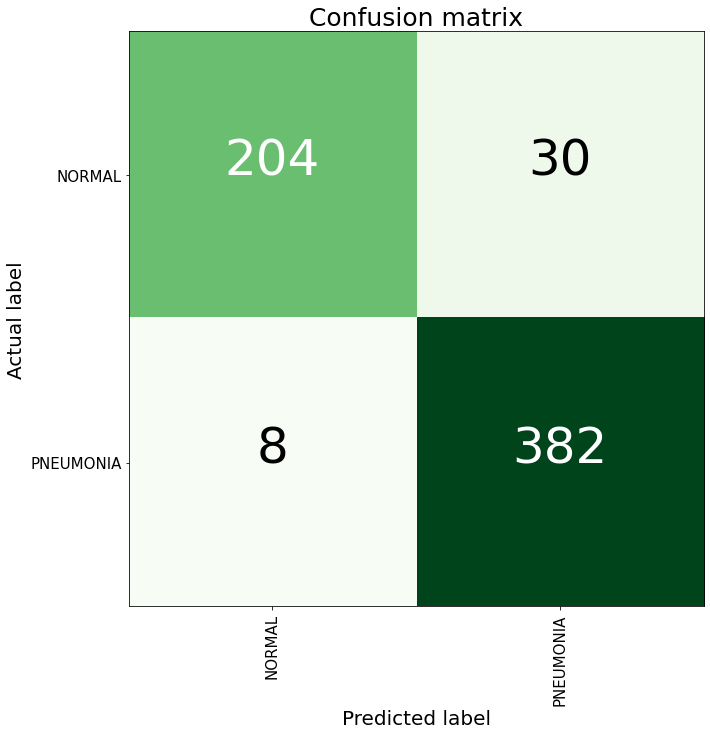

In [34]:
# Predict the values from the test data
y_pred = saved_model.predict(X_test)
y_pred_Classes = np.argmax(y_pred, axis = 1) 
trueY = np.argmax(y_test, axis = 1) 

# confusion matrix
confusionMTX = confusion_matrix(trueY, y_pred_Classes) 

# plot the confusion matrix
plot_confusion_matrix(confusionMTX, classes = labels.classes_)


In [34]:
print(classification_report(trueY, y_pred_Classes))

              precision    recall  f1-score   support

           0       0.96      0.87      0.91       234
           1       0.93      0.98      0.95       390

    accuracy                           0.94       624
   macro avg       0.94      0.93      0.93       624
weighted avg       0.94      0.94      0.94       624



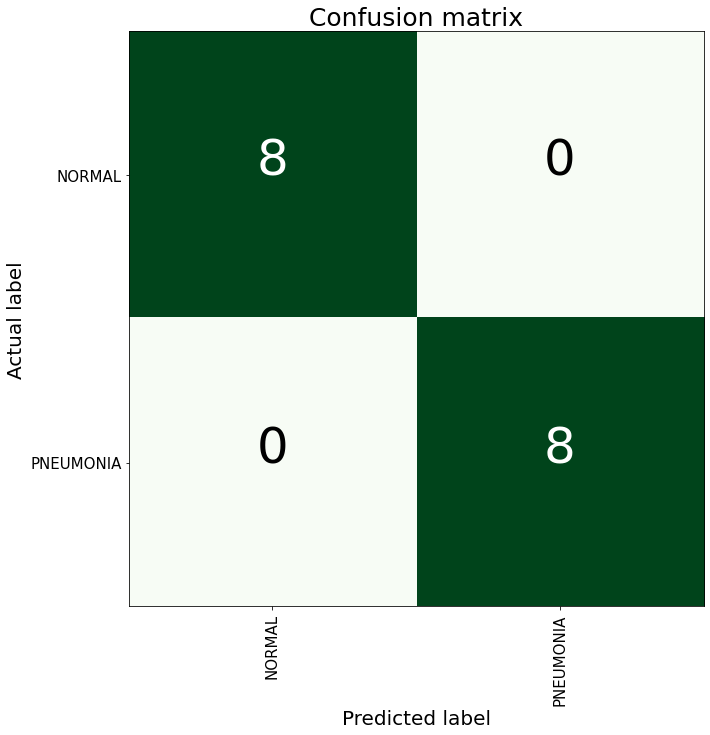

In [35]:
# Predict the values from the val data
y_val_pred = saved_model.predict(X_val)
y_val_pred_Classes = np.argmax(y_val_pred, axis = 1) 
true_val_Y = np.argmax(y_val, axis = 1) 

# confusion matrix
confusionMTX = confusion_matrix(true_val_Y, y_val_pred_Classes) 

# plot the confusion matrix
plot_confusion_matrix(confusionMTX, classes = labels.classes_)

In [41]:
print(classification_report(true_val_Y, y_val_pred_Classes))


#Final score and accuracy of the model

score, acc = saved_model.evaluate(X_val,y_val)
 
print('Validation loss:', score,'   Validation accuracy:', acc)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         8

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16

1/1 [==============================] - 0s 19ms/step - loss: 0.1922 - accuracy: 1.0000
Validation loss: 0.19215507805347443    Validation accuracy: 1.0
